In [2]:
import pandas as pd
import numpy as np
import folium
from sklearn.cluster import KMeans
from math import *
import matplotlib.pyplot as plt

### 데이터 로드, longitude 태평양중심

In [652]:
data = pd.read_csv('C:/Users/renz/Downloads/1205_data.csv')
data['LON'] = data['LON'].apply(lambda x : (x - 360) if x>0 else x )

### MMSI3 그룹화해서 개수 보기

In [191]:
data.groupby('MMSI3').count()['MMSI'].head()

MMSI3
209087000_4_1    141
209087000_4_2     47
209087000_8_2     48
209087000_8_3     39
209087000_8_5     94
Name: MMSI, dtype: int64

### MMSI3 기준으로 배가 몇개인지 확인

In [192]:
len(data.groupby('MMSI3').count())

2783

##### 배 경로 시각화(간단 코드)

In [193]:
data1 = data[data['MMSI3']=='636092379_83_3']
data1 = data1.reset_index()
m = folium.Map(location=[data1.loc[0,'LAT'], data1.loc[0,'LON']], zoom_start=1)
for i in range(data1.shape[0]):
    folium.CircleMarker(location=[data1.loc[i,'LAT'], data1.loc[i,'LON']], color = 'red', radius = 0.05).add_to(m)
m

KeyError: 'the label [0] is not in the [index]'

### train, test set 나누기

In [659]:
test = pd.concat([data, pd.DataFrame({'ETA4':data['ETA3'].apply(lambda x: x[:7].replace('-', ''))})], axis = 1).groupby('MMSI3').first().reset_index()
test2 = test[test['ETA4'].apply(lambda x: x in ['201808', '201807'])]
test3 = data[data['MMSI3'].isin(test2['MMSI3'])]

In [661]:
train = data[data.MMSI3.isin(test3.MMSI3) == False] 

In [669]:
data = train

### 도착지점에 대하여...(가장 많은 도착지점은 어떤 항구인가?)

##### 항구가져오기

In [670]:
port = pd.read_csv('C:/Users/renz/Downloads/DATA/PORT_MERGE_out.csv')

In [671]:
df1 = data.groupby('MMSI3').last()
L2 = []
for i,j,k in zip(df1.index, df1['LAT'], df1['LON']):
    L1 = []
    for l1, l2 in zip(port['LAT'], port['LON']):
        R = 6373.0 
        lat1 = radians(j) 
        lon1 = radians(k) 
        lat2 = radians(l1) 
        lon2 = radians(l2) 
        dlon = lon2 - lon1 
        dlat = lat2 - lat1 
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2 
        c = 2 * atan2(sqrt(a), sqrt(1 - a)) 
        distance = R * c
        L1.append(distance)
    L2.append([min(L1), port.iloc[L1.index(min(L1)),0], port.iloc[L1.index(min(L1)),1], port.iloc[L1.index(min(L1)),2]])

##### 2828개의 ship, 옆에 LAT, LON 붙이기

In [689]:
port_count = pd.DataFrame(L2, columns = ['distance', 'port_id', 'LAT', 'LON']).reset_index(drop=True).groupby('port_id').agg({'distance':'count', 'LAT':'mean', 'LON':'mean'}).reset_index().sort_values(by='distance', ascending=False)
df2 = port_count[port_count.port_id.isin(['USOAK', 'USLGB', 'KRPUS', 'JPSHS', 'MXZLO', 'CNYTN'])].reset_index(drop=False)
df2

,index,port_id,distance,LAT,LON
0,89,USOAK,235,37.797840,-122.286404
1,63,KRPUS,136,35.101620,-230.963950
2,88,USLGB,122,33.754929,-118.214344
3,52,JPSHS,118,33.937665,-229.076200
4,68,MXZLO,83,19.077290,-104.322500
5,32,CNYTN,70,22.575000,-245.723499


### 도착지(어떤 항구)를 기준으로 5km이내 모든 경로 가져오기

In [693]:
def port_5km(data, lat, lon):
    data1 = data.groupby(['MMSI3']).last()
    L1 = []
    
    for i,j,k in zip(data1.index, data1['LAT'], data1['LON']):
        R = 6373.0 
        lat1 = radians(j) 
        lon1 = radians(k) 
        lat2 = radians(lat) 
        lon2 = radians(lon)
        dlon = lon2 - lon1 
        dlat = lat2 - lat1 
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2 
        c = 2 * atan2(sqrt(a), sqrt(1 - a)) 
        distance = R * c
        L1.append(distance)

    df1 = pd.DataFrame(list(zip(data1.index, L1)), columns = ['MMSI3', 'distance'])
    df2 = df1[df1['distance'] <= 5]['MMSI3'].tolist()
    df3 = data[data['MMSI3'].isin(df2)].reset_index(drop=True)
    
    return df3

In [1130]:
# 필요한 항구 정보를 넣자.
port_id = 'JPSHS'
port_ais = port_5km(data=data, lat=df2.loc[df2.port_id.tolist().index(port_id), 'LAT'], lon=df2.loc[df2.port_id.tolist().index(port_id), 'LON'])
# port_ais

### port_ais를 이용하여 10분위 수 가져오기

In [695]:
def ten_number(data):
    L1 = list()
    for i, j in data.groupby('MMSI3').agg({'MMSI3': 'unique', 'MMSI': 'count'}).reset_index(drop=True).apply(lambda x: (x.MMSI3[0], x.MMSI), axis=1).tolist():
        for k in range(0, 11, 1):
            k = k/10
            df1 = data[data['MMSI3'] == i][['MMSI3', 'LAT', 'LON']].reset_index()
            
            if k == 0:
                L2 = list()
                L2.extend(list(df1[['MMSI3', 'LAT', 'LON']].iloc[0, :]))
            elif 0 < k < 1:
                L2.extend(list(df1[['LAT', 'LON']].iloc[int(round(j*k)), :]))
            else:
                L2.extend(list(df1[['LAT', 'LON']].iloc[-1, :]))
        L1.append(L2)

    L2 = pd.DataFrame(L1)
    
    
    if pd.isnull(L2).sum().sum() != 0:
        print('exist null...!!!!!')
    
    return L2

In [1131]:
df3 = ten_number(port_ais)
# df3

### k means clustring(계층적으로....)

In [1120]:
def visualization(data, sorted_L, i):
    print(i)
    data3 = data
    L = sorted_L
    for i, j in enumerate(L):
        data_cluster = data3[np.array(data3.iloc[:,-1:]).tolist() == j][['MMSI3', 'LAT', 'LON']]
        L2 = data_cluster['MMSI3'].unique()
        for k in L2:
                plt.subplot(1, 2, i+1)
                plt.plot(data_cluster[data_cluster['MMSI3'] == k]['LON'], data_cluster[data_cluster['MMSI3'] == k]['LAT'], 
                         'rs--', linewidth = .1, markersize = .1)
    
    return plt.show()

In [1121]:
def mean_test(data):
    mean = data.describe().loc['mean',:]

    L = list()
    for i,j in zip(mean, data.columns):
        sum = 0
        for k in data.index:
#             sum = sum + (i-data[j][k])**2
            sum = sum + abs(i-data[j][k])
        L.append(round(sum,2))
    L1 = np.mean(L)
    
    return L1

In [1122]:
def deepen(data, ten_number_data):
    data3 = data
    
    data_depth2_1 = data3[data3['cluster']==0].reset_index(drop=True)
    data_depth2_2 = data3[data3['cluster']==1].reset_index(drop=True)

    X_depth2_1 = np.array(ten_number_data[ten_number_data[0].isin(data_depth2_1['MMSI3'].unique())].iloc[:,1:])
    X_depth2_2 = np.array(ten_number_data[ten_number_data[0].isin(data_depth2_2['MMSI3'].unique())].iloc[:,1:])

    try:
#         df1 = pd.DataFrame(ten_number_data[ten_number_data[0].isin(data_depth2_1['MMSI3'].unique())])
#         mean_result = mean_test(data=df1.groupby([0]).mean())
#         if mean_result < 25:
        kmeans_depth2_1 = KMeans(n_clusters=2, random_state=0).fit(X_depth2_1)
        del data_depth2_1['cluster']
        depth2_1 = pd.DataFrame({'MMSI3' : ten_number_data[ten_number_data[0].isin(data_depth2_1['MMSI3'].unique())].iloc[:,0].tolist(), 'cluster' : list(kmeans_depth2_1.labels_)})
        depth2_1_mg = pd.merge(data_depth2_1, depth2_1, how='left', on=['MMSI3'])
    except:
        pass

    try:
#         df2 = pd.DataFrame(ten_number_data[ten_number_data[0].isin(data_depth2_2['MMSI3'].unique())])
#         mean_test(data=df2.groupby([0]).mean())
#         mean_result = mean_test(data=df1.groupby([0]).mean())
#         if mean_reslut < 25:
        kmeans_depth2_2 = KMeans(n_clusters=2, random_state=0).fit(X_depth2_2)
        del data_depth2_2['cluster']
        depth2_2 = pd.DataFrame({'MMSI3' : ten_number_data[ten_number_data[0].isin(data_depth2_2['MMSI3'].unique())].iloc[:,0].tolist(), 'cluster' : list(kmeans_depth2_2.labels_)})
        depth2_2_mg = pd.merge(data_depth2_2, depth2_2, how='left', on=['MMSI3'])    
    except:
        pass

    try:
        return depth2_1_mg, depth2_2_mg
    except:
        try:
            return depth2_1_mg
        except:
            try:
                return depth2_2_mg
            except:
                pass

In [1123]:
def kmeans_clustering(port_ais_data, ten_number_data):
    df1 = port_ais_data
    data22 = ten_number_data.iloc[:,1:]
    
    df2 = pd.DataFrame(ten_number_data[ten_number_data[0].isin(df1['MMSI3'].unique())])
    mean_test(data=df2.groupby([0]).mean())
    
    
    kmeans = KMeans(n_clusters=2, random_state=0).fit(np.array(data22))

    data2 = pd.DataFrame({'MMSI3' : ten_number_data.loc[:,0].tolist(), 'cluster' : list(kmeans.labels_)})
    data3 = pd.merge(df1, data2, how='left', on=['MMSI3'])
    
    L = sorted(data3['cluster'].unique())
    
    plt.figure(figsize=(5, 2))
    # DEPTH 1
    visualization(data=data3, sorted_L=L, i='Depth 1')
    
    
    # DEPTH 2
    depth2_1_mg, depth2_2_mg = deepen(data=data3, ten_number_data=ten_number_data)
    plt.figure(figsize=(3, 2))
    visualization(data=depth2_1_mg, sorted_L=sorted(np.unique(depth2_1_mg.iloc[:,-1:])), i='Depth2-1')
    plt.figure(figsize=(3, 2))
    visualization(data=depth2_2_mg, sorted_L=sorted(np.unique(depth2_2_mg.iloc[:,-1:])), i='Depth2-2')

    
    # DEPTH 3
    depth3_1_mg, depth3_2_mg = deepen(data=depth2_1_mg, ten_number_data=ten_number_data)
    plt.figure(figsize=(2, 1))
    visualization(data=depth3_1_mg, sorted_L=sorted(np.unique(depth3_1_mg.iloc[:,-1:])), i='Depth3-1')
    plt.figure(figsize=(2, 1))
    visualization(data=depth3_2_mg, sorted_L=sorted(np.unique(depth3_2_mg.iloc[:,-1:])), i='Depth3-2')
    
    
    try:
        depth3_3_mg, depth3_4_mg = deepen(data=depth2_2_mg, ten_number_data=ten_number_data)
        plt.figure(figsize=(2, 1))
        visualization(data=depth3_3_mg, sorted_L=sorted(np.unique(depth3_3_mg.iloc[:,-1:])), i='Depth3-3')
        plt.figure(figsize=(2, 1))
        visualization(data=depth3_4_mg, sorted_L=sorted(np.unique(depth3_4_mg.iloc[:,-1:])), i='Depth3-4')
    except:
        try:
            depth3_3_mg = deepen(data=depth2_2_mg, ten_number_data=ten_number_data)
            plt.figure(figsize=(2, 1))
            visualization(data=depth3_3_mg, sorted_L=sorted(np.unique(depth3_3_mg.iloc[:,-1:])), i='Depth3-3')
        except:
            print('군집이 더 이상 나눠지지 않습니다.')
            try:
                depth3_4_mg = deepen(data=depth2_2_mg, ten_number_data=ten_number_data)
                plt.figure(figsize=(2, 1))
                visualization(data=depth3_4_mg, sorted_L=sorted(np.unique(depth3_4_mg.iloc[:,-1:])), i='Depth3-4')
            except:
                print('군집이 더 이상 나눠지지 않습니다.')
    
    return

Depth 1


C:\tools\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


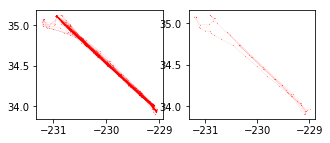

Depth2-1


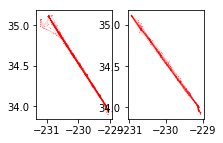

Depth2-2


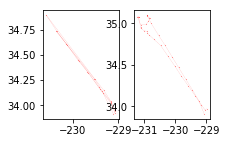

Depth3-1


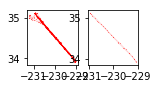

Depth3-2


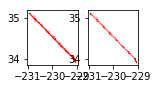

Depth3-3


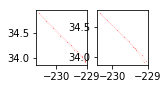

In [1132]:
kmeans_clustering(port_ais_data=port_ais, ten_number_data=df3)

In [ ]:
df1 = data[data['MMSI3'].apply(lambda x: x in list(L11[0]))]
data10 = L11.iloc[:, 1:]
data2 = L11[0]
X = np.array(data10)
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
data2 = pd.DataFrame({'MMSI3' : data2, 'cluster' : list(kmeans.labels_)})
data3 = pd.merge(df1, data2, how='left', on=['MMSI3'])
# colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
L = sorted(data3['cluster'].unique())
plt.figure(figsize=(15, 15))
for i, j in enumerate(L):
    data_cluster = data3[data3['cluster'] == j][['MMSI3', 'LAT', 'LON']]
    L2 = data_cluster['MMSI3'].unique()
    for k in L2:
        plt.subplot(3, 2, i+1)
        plt.plot(data_cluster[data_cluster['MMSI3'] == k]['LON'], 
                 data_cluster[data_cluster['MMSI3'] == k]['LAT'], 
                 'rs--', linewidth = .1, markersize = .1)
plt.show()

In [ ]:
L1 = L1[L1[0].isin(list(data2[data2['cluster']==0]['MMSI3']))]
list(data2[data2['cluster']==0]['MMSI3'])
df5 = pd.concat([L1, pd.DataFrame(kmeans.labels_, columns = ['cluster'])], axis=1)
df6 = data[data['MMSI3'].apply(lambda x: x in list(df5[df5['cluster']==1][0]))]
df6 = data[data['MMSI3'].isin(list(df5[df5['cluster']==1][0]))]
df6